# Rainfall-runoff experiment

In this experiment, we'll try to learn model for simple artificial dataset of simulated rainfall-runoff scenario.

The task is to forecast runoff (prutok) based on rainfall during time. We can test longer dependencies through time and power of LSTM networks.

In [2]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN

First, we need a dataset. Here's a code that simulates one river scenario.

There are two methods: `get_precip` for rainfall and `gen_discharge` for runoff. Runoff is lagged in time based on topography of the river (see `BASINS = [BASIN(area, lag)]` array)

In [3]:
MIN_EVENT_TIME = 5
MAX_EVENT_TIME = 20
MIN_EVENT_POWER = 0.05
MAX_EVENT_POWER = 0.5

BASINS = [
    (0.02, 20),
    (0.02, 30),
    (0.01, 35),
    (0.03, 41),
    (0.02, 45),
    (0.01, 54),
    (0.02, 65),
    (0.01, 75),
]

def generate_precipitation(num_samples, events_ratio):  
    
    result = np.zeros(num_samples)
    num_events = int(events_ratio * num_samples)
    
    for event_start in random.sample(range(num_samples - MAX_EVENT_TIME), num_events):
        event = np.zeros((num_samples,))
        event_time = random.randint(MIN_EVENT_TIME, MAX_EVENT_TIME)
        event_power = random.random() * (MAX_EVENT_POWER - MIN_EVENT_POWER) + MIN_EVENT_POWER
        event[event_start: event_start + event_time] = (np.cos(np.linspace(-np.pi, np.pi, num=event_time)) * 0.5 + 0.5) * event_power
        result += event
    
    return result

def generate_discharge(basins, precip, runoff):            
    all_precip = np.zeros(precip.shape)
    
    for basin in basins:
        lagged = np.roll(precip * basin[0], basin[1])
        lagged[:basin[1]] = 0
        all_precip += lagged
        
    discharge = np.zeros(precip.shape)
        
    for i in range(1, len(discharge)):
        discharge[i] = discharge[i - 1]  * (1 - runoff) + all_precip[i]
        
    return discharge

Let's see how our simulated river behaves:

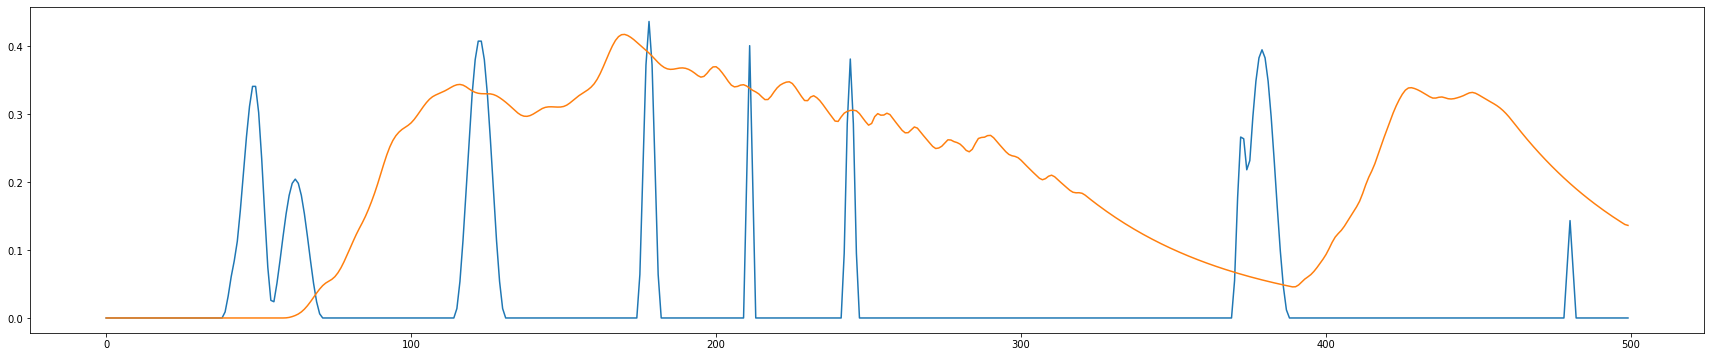

In [4]:
precip = generate_precipitation(500, 0.02)
discharge = generate_discharge(BASINS, precip, 0.02)

plt.figure(figsize=(30,6))
plt.plot(precip)
plt.plot(discharge)
plt.show()

We can generate some training examples for this river and try fit a neural network model to see if the model can learn the river hidden behavior.

In [5]:
import random

NUM_SAMPLES = 2000
SEQ_LEN = 500

raw_train_X = [generate_precipitation(SEQ_LEN, 0.02) for i in range(NUM_SAMPLES)]
raw_train_Y = [generate_discharge(BASINS, precip_sample, 0.02) for precip_sample in raw_train_X]

## Feed-forward network

In [6]:
inputs = Input(shape=(SEQ_LEN,))
x = Dense(200, activation='tanh')(inputs)
x = Dense(200, activation='tanh')(x)
x = Dense(200, activation='tanh')(x)
outputs = Dense(SEQ_LEN, activation='linear')(x)

fnn_model = Model(inputs, outputs)
fnn_model.compile(optimizer='adam', loss='mse')
fnn_model.summary()

fnn_train_X = np.vstack(raw_train_X)
fnn_train_Y = np.vstack(raw_train_Y)

print("Input shape:", fnn_train_X.shape)
print("Target shape:", fnn_train_Y.shape)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               100200    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 500)               100500    
Total params: 281,100
Trainable params: 281,100
Non-trainable params: 0
_________________________________________________________________
Input shape: (2000, 500)
Target shape: (2000, 500)


In [7]:
progress = fnn_model.fit(fnn_train_X, fnn_train_Y, validation_split=0.1, epochs=25)

Epoch 1/25
57/57 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0024
Epoch 2/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 7.8469e-04
Epoch 3/25
57/57 [==============================] - 0s 3ms/step - loss: 5.7919e-04 - val_loss: 4.7551e-04
Epoch 4/25
57/57 [==============================] - 0s 3ms/step - loss: 3.8959e-04 - val_loss: 4.2046e-04
Epoch 5/25
57/57 [==============================] - 0s 4ms/step - loss: 3.2051e-04 - val_loss: 2.9170e-04
Epoch 6/25
57/57 [==============================] - 0s 3ms/step - loss: 2.6049e-04 - val_loss: 2.7208e-04
Epoch 7/25
57/57 [==============================] - 0s 3ms/step - loss: 2.3382e-04 - val_loss: 2.5914e-04
Epoch 8/25
57/57 [==============================] - 0s 3ms/step - loss: 2.2991e-04 - val_loss: 2.5337e-04
Epoch 9/25
57/57 [==============================] - 0s 4ms/step - loss: 2.1469e-04 - val_loss: 1.9641e-04
Epoch 10/25
57/57 [==============================] - 0s 4m

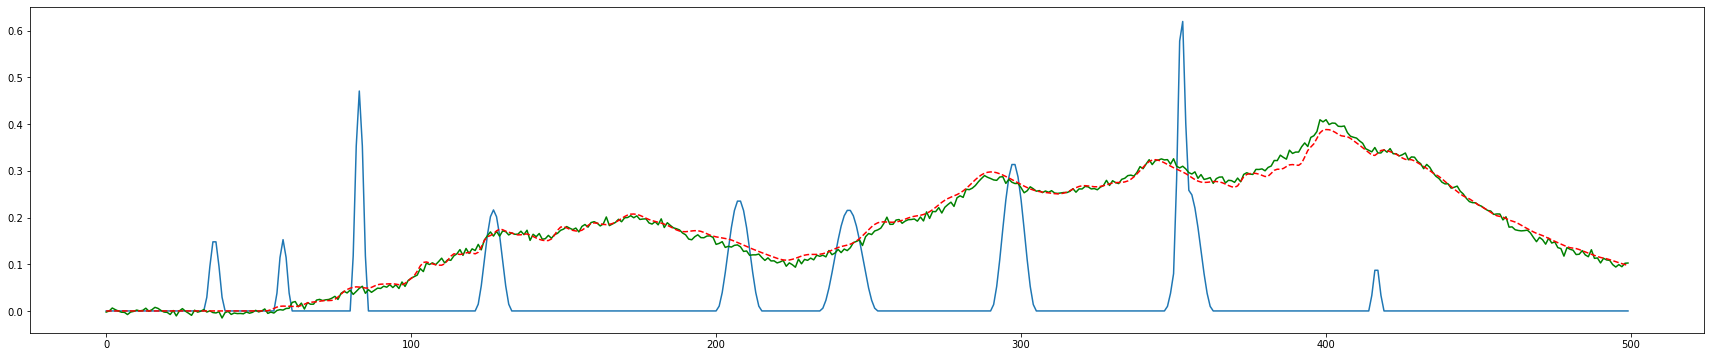

In [10]:
TEST_SEQ_LEN = 500
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.02)

prediction = fnn_model.predict(test_input.reshape(1, SEQ_LEN))[0]

plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Recurrent network

In [11]:
inputs = Input(shape=(None, 1))
x = LSTM(64, return_sequences=True, recurrent_activation='sigmoid')(inputs)
outputs = Dense(1, activation='linear')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X).reshape((NUM_SAMPLES, SEQ_LEN, 1))
train_Y = np.vstack(raw_train_Y).reshape((NUM_SAMPLES, SEQ_LEN, 1))

print("Input shape:", train_X.shape)
print("Target shape:", train_Y.shape)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          16896     
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Input shape: (2000, 500, 1)
Target shape: (2000, 500, 1)


In [13]:
progress = model.fit(train_X, train_Y, validation_split=0.1, epochs=15)

Epoch 1/15
57/57 [==============================] - 5s 85ms/step - loss: 0.0234 - val_loss: 0.0224
Epoch 2/15
57/57 [==============================] - 5s 85ms/step - loss: 0.0231 - val_loss: 0.0221
Epoch 3/15
57/57 [==============================] - 5s 85ms/step - loss: 0.0191 - val_loss: 0.0094
Epoch 4/15
57/57 [==============================] - 5s 84ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 5/15
57/57 [==============================] - 5s 84ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 6/15
57/57 [==============================] - 5s 84ms/step - loss: 9.3791e-04 - val_loss: 7.9130e-04
Epoch 7/15
57/57 [==============================] - 5s 84ms/step - loss: 8.0706e-04 - val_loss: 8.0520e-04
Epoch 8/15
57/57 [==============================] - 5s 84ms/step - loss: 6.2946e-04 - val_loss: 5.0455e-04
Epoch 9/15
57/57 [==============================] - 5s 84ms/step - loss: 5.7907e-04 - val_loss: 5.5244e-04
Epoch 10/15
57/57 [==============================] - 5s 84ms/step - loss: 4.5

In [14]:
model.save_weights("rr_lstm.npy")

In [17]:
TEST_SEQ_LEN = 2000
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.02)

In [18]:
prediction = model.predict(test_input.reshape((1, TEST_SEQ_LEN, 1)))[0]

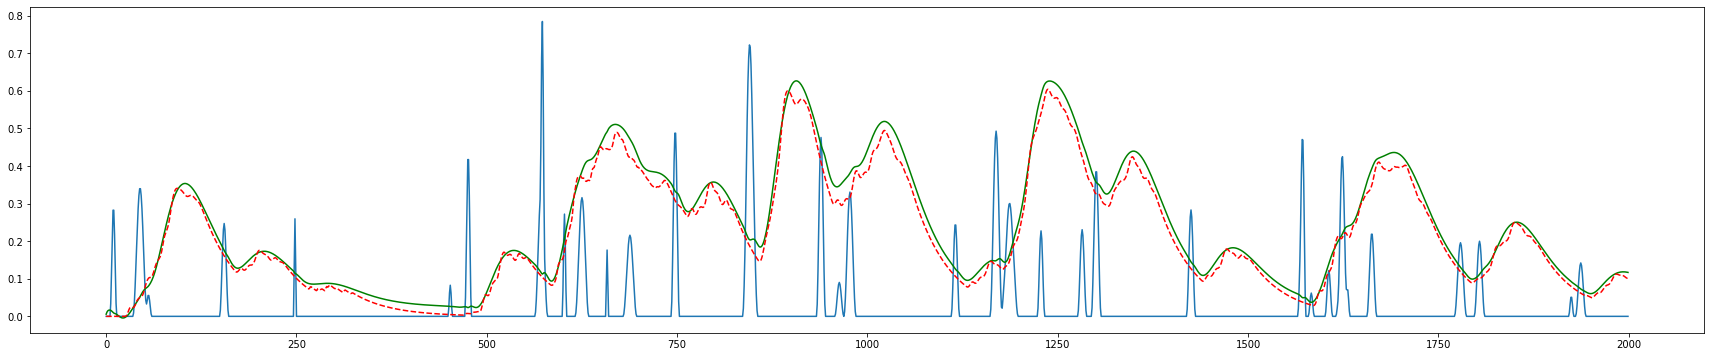

In [19]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Sliding window feed forward network
Feed-forward network can be used for longer inputs by "sliding" it over the input interval to gather enough context.

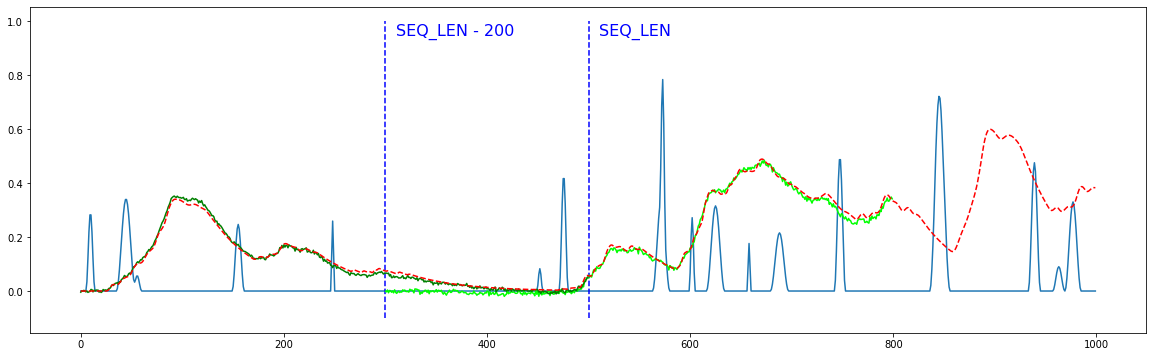

In [41]:
p1 = fnn_model.predict(test_input[:SEQ_LEN].reshape((1, SEQ_LEN)))[0]
p2 = fnn_model.predict(test_input[SEQ_LEN - 200: 2 * SEQ_LEN - 200].reshape((1, SEQ_LEN)))[0]

plt.figure(figsize=(20,6))
plt.plot(test_input[:1000])
plt.plot([SEQ_LEN - 200, SEQ_LEN - 200], [-0.1, 1.0], 'b--')
plt.text(SEQ_LEN - 190, 0.95, "SEQ_LEN - 200", c='b', size="16")
plt.plot([SEQ_LEN, SEQ_LEN], [-0.1, 1.0], 'b--')
plt.text(SEQ_LEN + 10, 0.95, "SEQ_LEN", c='b', size="16")
plt.plot(range(SEQ_LEN - 200,  2 * SEQ_LEN - 200), p2, 'lime')
plt.plot(range(SEQ_LEN), p1, 'green')
plt.plot(test_output[:1000], 'r--')
plt.show()

## Continuous prediction with LSTM network
LSTM can be used for daily prediction inslead of prediction on the full input.

We are **not** going to compile the model. 
We do not need training and inference will be much faster without gradient tracking turned off.

In [20]:
inputs = Input(batch_shape=(1, 1, 1))
x = LSTM(64, return_sequences=True, recurrent_activation='sigmoid', stateful=True)(inputs)
outputs = Dense(1, activation='linear')(x)
c_model = Model(inputs, outputs)
# c_model.compile(optimizer='adam', loss='mse')
c_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(1, 1, 1)]               0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 1, 64)                16896     
_________________________________________________________________
dense_5 (Dense)              (1, 1, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


We are using the **same LSTM model instance** as above! Only sequence length is different.

In [21]:
c_model.load_weights("rr_lstm.npy")

First, the model is filled with the context from history

In [22]:
from tqdm import tqdm

START_OFFSET = 150
HISTORY_LEN = 500
PREDICTION_LEN = len(test_input) - HISTORY_LEN - START_OFFSET

c_prediction = START_OFFSET * [0]
c_model.reset_states()

for i in tqdm(range(HISTORY_LEN)):
    single_pred = c_model.predict(test_input[i + START_OFFSET].reshape(1, 1, 1))[0][0][0]
    c_prediction.append(single_pred)

100%|██████████| 500/500 [00:19<00:00, 25.00it/s]


Next, the model predicts output day by day

In [23]:
for i in tqdm(range(PREDICTION_LEN)):
    daily_measure = test_input[START_OFFSET + HISTORY_LEN + i].reshape(1, 1, 1)
    single_pred = c_model.predict(daily_measure)[0][0][0]
    c_prediction.append(single_pred)

100%|██████████| 1350/1350 [00:54<00:00, 24.84it/s]


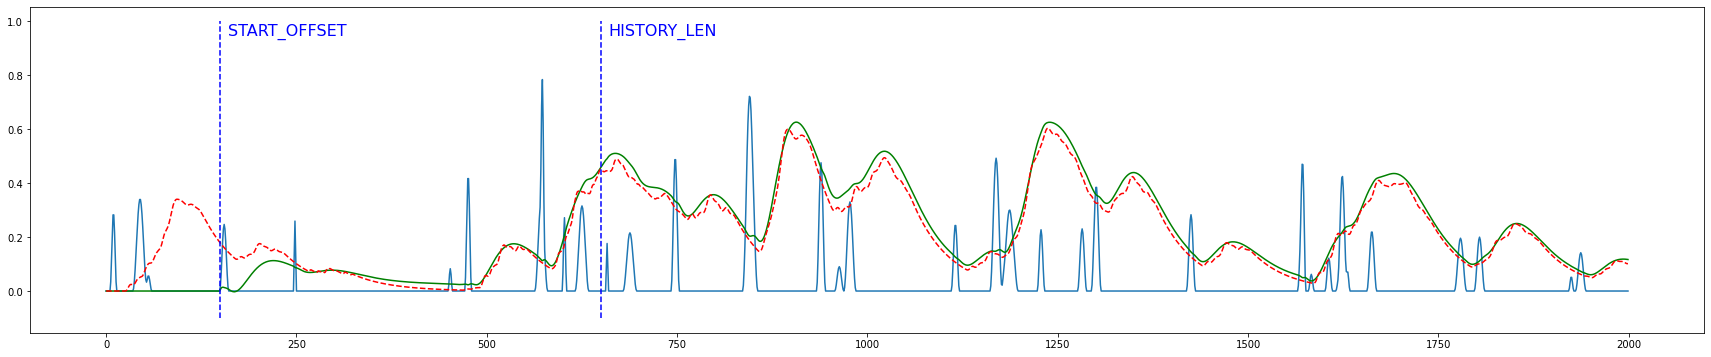

In [38]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(c_prediction, 'green')
plt.plot(test_output, 'r--')
plt.plot([START_OFFSET, START_OFFSET], [-0.1, 1.0], 'b--')
plt.text(START_OFFSET + 10, 0.95, "START_OFFSET", c='b', size="16")
plt.plot([START_OFFSET + HISTORY_LEN, START_OFFSET + HISTORY_LEN], [-0.1, 1.0], 'b--')
plt.text(START_OFFSET + HISTORY_LEN + 10, 0.95, "HISTORY_LEN", c='b', size="16")
plt.show()

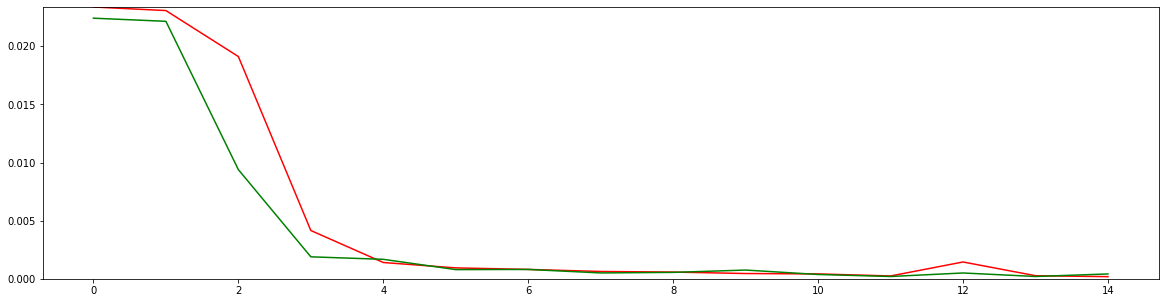

In [39]:
#utility code to plot loss history

loss_history = np.array(progress.history['loss'])
val_loss_history = np.array(progress.history['val_loss'])
                            
plt.figure(figsize=(20,5))
plt.ylim(ymin=0, ymax=max(np.max(loss_history), np.max(val_loss_history)))
plt.plot(loss_history, 'r-')
plt.plot(val_loss_history, 'g-')
plt.show()